# Analyze performance of LSTM (Model 2) on Shasta Reservoir

In this notebook, we analyze the performance of LSTM Model 2 using data from Shasta reservoir.
Recall that LSTM Model 2 takes in inflow and the day of the year (DOY) as input, and outputs the predicted release. Model 2 is also
autoregressive, i.e. previous outputs are fed in as inputs in the next timestep. This notebook is organized in serveral sections:

1. Data processing: manipulate data to use with the models
2. Analyze optimal hyperparameters, using results from grid search conducted in 1_model1_tuning.py
3. Plot performance on train, val, test sets. Get R2 measure.
4. Analyze relationship between cell states and observed storage

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

## Data Processing

In [2]:
from src.data.data_processing import *
from src.data.data_fetching import *
from torch.utils.data import DataLoader, TensorDataset

# Read in data, columns are [inflow, outflow, storage]
df = usbr_fetch_data(name='Shasta', vars=['inflow', 'outflow', 'storage'])
# Add day of the year (doy) as another column
df['doy'] = df.index.to_series().dt.dayofyear
# Select data window (beginning of 1944 to end of 2022)
df = df['1944-01-01':'2022-12-31'].copy()

In [3]:
# Run data processing pipeline
pipeline = processing_pipeline(train_frac=0.6, val_frac=0.2, test_frac=0.2, chunk_size=3*365, pad_value=-1)
# Train and val of shape (#chunks, chunksize, [inflow, outflow, storage, doy]), test of shape (timesteps, [inflow, outflow, storage, doy])
ts_train, ts_val, ts_test = pipeline.process_data(df) 

In [4]:
# Separate inputs(X) and targets (y)
# select inflow and doy as input features
X_train, X_val, X_test = ts_train[:, :, [0, 3]], ts_val[:, :, [0, 3]], ts_test[:, :, [0, 3]]
# select outflow as target feature
y_train, y_val, y_test = ts_train[:, :, [1]], ts_val[:, :, [1]], ts_test[:, :, [1]]

# Create PyTorch dataset and dataloader
dataset_train, dataset_val = (TensorDataset(X_train, y_train), TensorDataset(X_val, y_val))
# shuffle = False to preserve time order
dataloader_train, dataloader_val = (DataLoader(dataset_train, batch_size=1, shuffle=False), 
                                                     DataLoader(dataset_val, batch_size=1, shuffle=False))

## Analyze Optimal Hyperparameters

We conducted a small grid search around the optimal parameters of Model 1 (since the two models are similar). The search space is as follows: \
Number LSTM layers; 1\
Hidden size (LSTM): 25, 30, 35\
Hidden size (FF): 10, 15, 20\
Dropout probability: 0.3

On 5 random seeds: 0, 10, 100, 1000, 10000 which we want to average performance over.

In [5]:
# load in results from grid search
grid_df = pd.read_csv('report/results/hyperparameter_tuning/model2_tuning.csv', index_col=0)

In [6]:
# average performance over the random seeds
num_random_seeds = 5
grid_df['param_id'] = np.repeat(np.arange(int(len(grid_df) / num_random_seeds)), num_random_seeds)
grid_df_mean = grid_df.groupby('param_id').mean()
grid_df_mean.drop(columns=['random_seed'], inplace=True)

In [7]:
# save sorted df
grid_df_mean.sort_values(by=['val_error'], axis=0, inplace=True)
grid_df_mean.to_csv('report/results/hyperparameter_tuning/model1_avg_tuning.csv')
grid_df_mean[:10]

,num_layers,hidden1,hidden2,dropout,epochs_trained,val_error
param_id,,,,,,
7,1.0,35.0,15.0,0.3,53.8,0.395253
4,1.0,30.0,15.0,0.3,72.0,0.397243
8,1.0,35.0,20.0,0.3,50.0,0.407889
2,1.0,25.0,20.0,0.3,54.6,0.412745
1,1.0,25.0,15.0,0.3,53.6,0.416251
5,1.0,30.0,20.0,0.3,47.2,0.417171
6,1.0,35.0,10.0,0.3,65.6,0.426811
0,1.0,25.0,10.0,0.3,62.4,0.429532
3,1.0,30.0,10.0,0.3,47.0,0.433843


### Train model with optimal hyperparaeters
Training is done on auxillary script 4b_model2_analysis.py

The optimal hyperparameters are:
Number  of LSTM layers: 1\
LSTM hidden units: 35\
FF hidden units: 15\
dropout: 0.3

In [8]:
from src.models.model_zoo import *
from src.models.predict_model import *
from src.models.train_model import *

In [9]:
# instantiate model
input_size = 2
hidden_size1 = 30
hidden_size2 = 15
output_size = 1
dropout_prob = 0.3

torch.manual_seed(0)
model2 = LSTMModel2(input_size=input_size, hidden_size1=hidden_size1, 
                             hidden_size2=hidden_size2, output_size=output_size, dropout_prob=dropout_prob, initial_output=0)

In [10]:
count_parameters(model2)

4681

In [11]:
# load saved model parameters
model2.load_state_dict(torch.load('src/models/saved_models/model2.pt'))

<All keys matched successfully>

## Evaluate Model 2

In [12]:
from src.models.predict_model import *
from sklearn.metrics import r2_score

In [13]:
model2.eval()

LSTMModel2(
  (lstm_cell): LSTMCell(3, 30)
  (dropout1): Dropout(p=0.3, inplace=False)
  (linear1): Linear(in_features=30, out_features=15, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=15, out_features=1, bias=True)
)

### Evaluate performance in training

In [14]:
# flatten and remove pads
y_hat_train, y_true_train = flatten_rm_pad(y_hat=model2(X_train)[0].detach(), y=y_train)

# check dimensions of datetime
original_train_len = int(round(df['1944-01-01':'2022-12-31'].shape[0] * pipeline.train_frac))
original_val_len = int(round(df['1944-01-01':'2022-12-31'].shape[0] * pipeline.val_frac))
original_test_len = df['1944-01-01':'2022-12-31'].shape[0] - (original_train_len + original_val_len)

assert len(y_true_train) == original_train_len

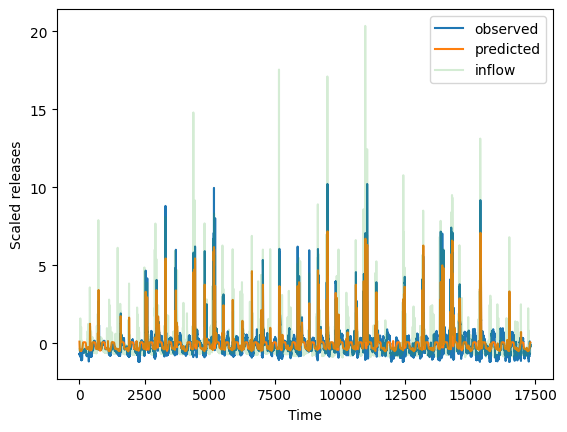

In [15]:
plot_predicted_true(y_hat=y_hat_train, y=y_true_train)
plt.plot(((df.inflow[:(original_train_len)] - df.inflow[:(original_train_len)].mean()) / df.inflow[:(original_train_len)].std()).values, 
         alpha=0.2, label='inflow')
plt.legend()
plt.show()

In [16]:
# R-squared
r2_score(y_true=y_true_train, y_pred=y_hat_train)

0.7325630682970579

### Evaluate performance in testing

In [17]:
# flatten and remove pads
y_hat_test, y_true_test = flatten_rm_pad(y_hat=model2(X_test)[0].detach(), y=y_test)
# check dimensions
assert len(y_true_test) == len(df.index) - (original_train_len + original_val_len)

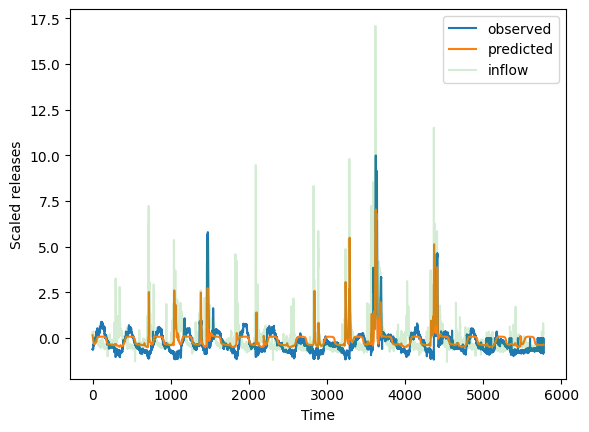

In [18]:
plot_predicted_true(y_hat=y_hat_test, y=y_true_test)
plt.plot(((df.inflow[(original_train_len+original_val_len):] - df.inflow[(original_train_len+original_val_len):].mean()) / df.inflow[(original_train_len+original_val_len):].std()).values, 
         alpha=0.2, label='inflow')
plt.legend()
plt.show()

In [19]:
# R-squared
r2_score(y_true=y_true_test, y_pred=y_hat_test)

0.37452093517921925

### Performance on the validation set

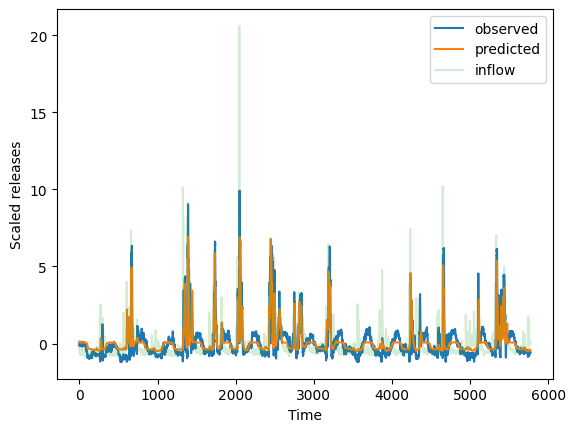

In [20]:
y_hat_val, y_true_val = flatten_rm_pad(y_hat=model2(X_val)[0].detach(), y=y_val)
assert len(y_true_val) == original_val_len

plot_predicted_true(y_hat=y_hat_val, y=y_true_val)
plt.plot(((df.inflow[original_train_len:(original_train_len+original_val_len)] - df.inflow[original_train_len:(original_train_len+original_val_len)].mean()) / df.inflow[original_train_len:(original_train_len+original_val_len)].std()).values, 
         alpha=0.2, label='inflow')
plt.legend()
plt.show()

In [21]:
r2_score(y_true_val, y_hat_val)

0.6941026998767598

## Analyze cell memory states

### Analyze correlations

In [22]:
from src.models.analyze_lstm_cell import *

In [23]:
# Get cell states, shape is (# chunks, timesteps, hidden size)
cell_train = model2(X_train)[1].detach()
cell_val = model2(X_val)[1].detach()
cell_test = model2(X_test)[1].detach()

In [24]:
# Get storage states, shape is (timesteps, )
storage_train = df.storage[:original_train_len].values
storage_val = df.storage[original_train_len:(original_train_len+original_val_len)].values
storage_test = df.storage[(original_train_len+original_val_len):].values

In [26]:
correlation_data = {'training':cell_correlations(cell_states=cell_train, storage_states=storage_train),
                    'validation': cell_correlations(cell_states=cell_val, storage_states=storage_val),
                    'testing': cell_correlations(cell_states=cell_test, storage_states=storage_test)}
df_corr = pd.DataFrame(correlation_data)

In [31]:
# Select cell with correlation > 0.30
df_corr.loc[df_corr['training'] > 0.30, :].sort_values(by='training', ascending=False)

,training,validation,testing
27,0.412867,0.580348,0.490523
6,0.407696,0.501416,0.444177
20,0.400892,0.540420,0.491468
3,0.392188,0.559196,0.485417
19,0.388398,0.528558,0.478481
9,0.353684,0.352729,0.312761
0,0.335752,0.494170,0.438125
15,0.316050,0.536782,0.416171
28,0.302707,0.443631,0.396675


### Plot cell state vs observed storage

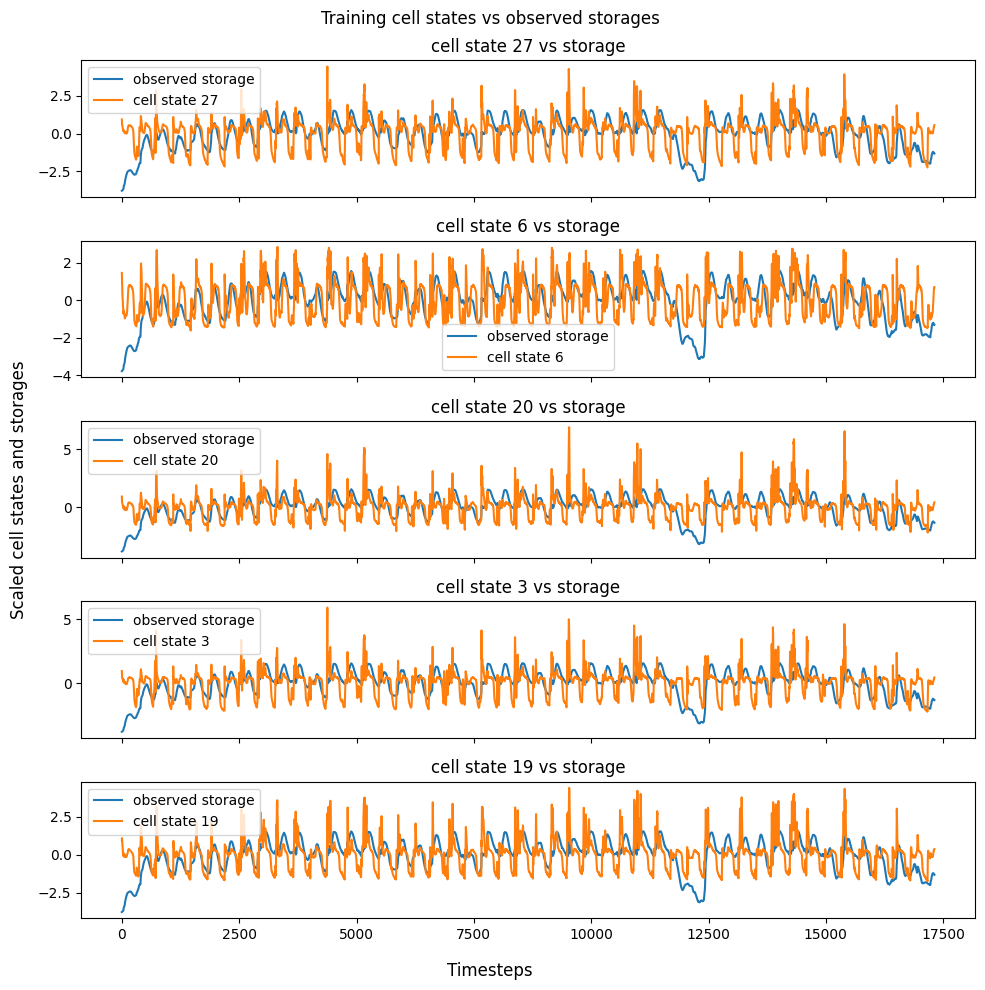

In [32]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 10), sharex=True)
plot_storage_cell(cell_states_all=cell_train, storage_states=storage_train, cell_id=27, ax=axes[0])
plot_storage_cell(cell_states_all=cell_train, storage_states=storage_train, cell_id=6, ax=axes[1])
plot_storage_cell(cell_states_all=cell_train, storage_states=storage_train, cell_id=20, ax=axes[2])
plot_storage_cell(cell_states_all=cell_train, storage_states=storage_train, cell_id=3, ax=axes[3])
plot_storage_cell(cell_states_all=cell_train, storage_states=storage_train, cell_id=19, ax=axes[4])

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend(loc='upper left')
axes[4].legend(loc='upper left')

fig.supxlabel('Timesteps')
fig.supylabel('Scaled cell states and storages')
fig.suptitle('Training cell states vs observed storages')
plt.tight_layout()
plt.show()

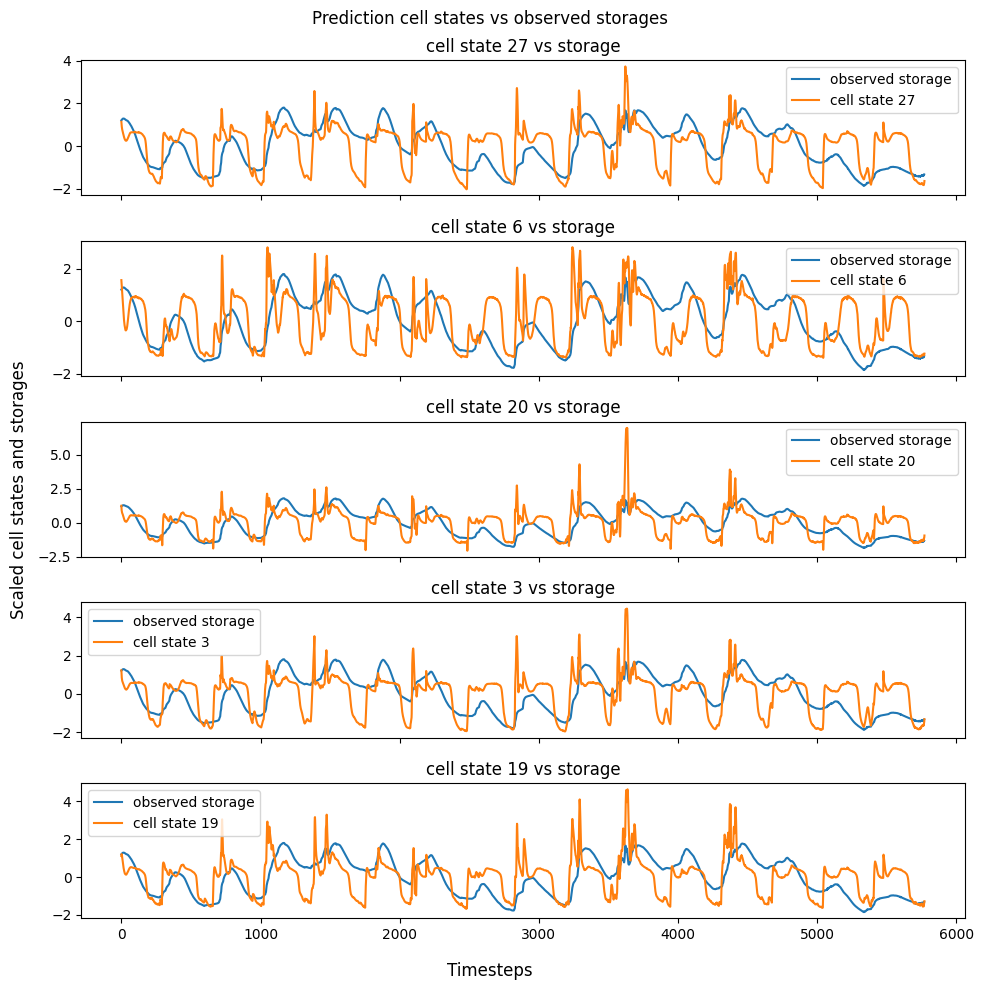

In [33]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 10), sharex=True)
plot_storage_cell(cell_states_all=cell_test, storage_states=storage_test, cell_id=27, ax=axes[0])
plot_storage_cell(cell_states_all=cell_test, storage_states=storage_test, cell_id=6, ax=axes[1])
plot_storage_cell(cell_states_all=cell_test, storage_states=storage_test, cell_id=20, ax=axes[2])
plot_storage_cell(cell_states_all=cell_test, storage_states=storage_test, cell_id=3, ax=axes[3])
plot_storage_cell(cell_states_all=cell_test, storage_states=storage_test, cell_id=19, ax=axes[4])

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend(loc='upper left')
axes[4].legend(loc='upper left')

fig.supxlabel('Timesteps')
fig.supylabel('Scaled cell states and storages')
fig.suptitle('Prediction cell states vs observed storages')
plt.tight_layout()
plt.show()

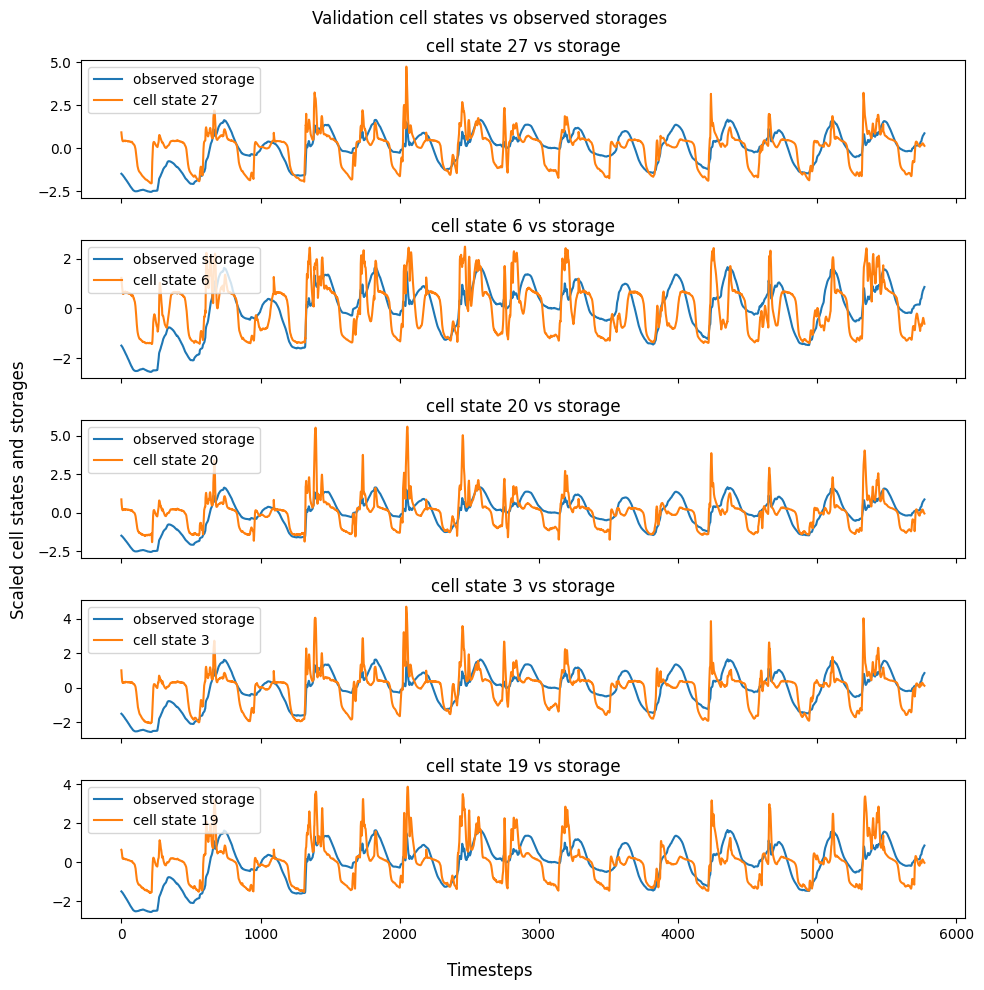

In [34]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 10), sharex=True)
plot_storage_cell(cell_states_all=cell_val, storage_states=storage_val, cell_id=27, ax=axes[0])
plot_storage_cell(cell_states_all=cell_val, storage_states=storage_val, cell_id=6, ax=axes[1])
plot_storage_cell(cell_states_all=cell_val, storage_states=storage_val, cell_id=20, ax=axes[2])
plot_storage_cell(cell_states_all=cell_val, storage_states=storage_val, cell_id=3, ax=axes[3])
plot_storage_cell(cell_states_all=cell_val, storage_states=storage_val, cell_id=19, ax=axes[4])

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend(loc='upper left')
axes[4].legend(loc='upper left')

fig.supxlabel('Timesteps')
fig.supylabel('Scaled cell states and storages')
fig.suptitle('Validation cell states vs observed storages')
plt.tight_layout()
plt.show()